Objective:
    
    Use Kaggle data to input a list of ingredients and retrieve recipes that can be made from them
    This is later used in program that reads an Image's text and returns possible recipes based on ingredients listed on the       paper. Also returns Dietary information regarding the meal
    
    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.display import display, HTML
%matplotlib inline

import ast #The lists of ingredients were shown as strings so needed this to change e.g. "[1,2,3]" to just [1,2,3] list type

# 1. Organizing Data for our purpose

In [2]:
ingredientsDF = pd.read_csv('ingredients_ConvertedFromPKL_File.csv')
rawRecipesDF = pd.read_csv('RAW_recipes.csv') 
rawInteractionsDF = pd.read_csv('RAW_interactions.csv')

In [3]:
ingredientsDF.head(4)

,Unnamed: 0,raw_ingr,raw_words,processed,len_proc,replaced,count,id
0,0,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507,4308
1,1,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507,4308
2,2,romaine lettuce leaf,3,romaine lettuce leaf,20,lettuce,4507,4308
3,3,iceberg lettuce leaf,3,iceberg lettuce leaf,20,lettuce,4507,4308


In [4]:
rawInteractionsDF.head(2)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."


In [5]:
'''
Nutrition information (calories (#), total fat (PDV), sugar (PDV) , sodium (PDV) , protein (PDV) , saturated fat
PDV is Percent Daily Value (% acquired from the food relative to the amount needed for a day (Like DRI))
'''
rawRecipesDF.head(6)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
5,apple a day milk shake,5289,0,1533,1999-12-06,"['15-minutes-or-less', 'time-to-make', 'course...","[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",NaN,"['milk', 'vanilla ice cream', 'frozen apple ju...",4


In [6]:
recipes= rawRecipesDF.copy()
recipes = recipes[['name','id','minutes','nutrition','n_steps','steps','description','ingredients','n_ingredients']]

In [7]:
recipes.drop([144074,109624],inplace = True) #Granola bars recipe. Minutes very long...outlier so just dropped

In [8]:
"""
This creates a dictionary with keys = 'raw_ingr' column and vals = 'replaced' column
Now can use this in recipes to check for keys and map to a value in the newly created column

"""
mappingDict = dict(ingredientsDF[['raw_ingr','replaced']].values) 
mappingDictBack=dict(ingredientsDF[['replaced','raw_ingr']].values) 


In [9]:
"""
For a pandas series with lists as the values in each row. This will be used through the .apply() on the series
to take each list inside the series (innerList) and map it to its values using dictionary created above.
"""
def mapInnerList(innerList):
    for i in range(len(innerList)):
        innerList[i]=mappingDict.get(innerList[i],innerList[i]) #get key value at index or keep original entry if key not found
    return innerList    


#SEE: https://stackoverflow.com/questions/6130768/return-none-if-dictionary-key-is-not-available

In [10]:
"""
See above explanation for this.
"""
recipes['ingredients']=rawRecipesDF['ingredients'].apply(ast.literal_eval)
recipes['baseIngrType']= recipes['ingredients'].apply(lambda inLst: mapInnerList(inLst)) 


#.apply() changes the original column too so this was only way I could find to change back ingredients column to original form before mapping

In [11]:
"""
Previous .apply() will make both baseIngrType and ingredients column the same so revert ingredients back from original
"""
recipes['ingredients']=rawRecipesDF['ingredients'].apply(ast.literal_eval)
recipes['nutrition']=recipes['nutrition'].apply(ast.literal_eval) #change lists '[chicken]' to [chicken]
recipes['steps']=recipes['steps'].apply(ast.literal_eval) 

# see https://stackoverflow.com/questions/44672561/convert-string-representation-of-list-into-list



#Lower case ingredients column for searches later on (in case user inputs capital letters)
recipes['ingredients']=recipes['ingredients'].apply(lambda itemsLst: [x.lower() for x in itemsLst])

#list comprehension inside lambda expression inside a apply for a series of a dataframe!!!!

In [12]:
"""
ADDED Avg rating(rating) and Num of Ratings columns(review)

See pd.merge() used to create recipes dataframe
"""
avgRatings=rawInteractionsDF.groupby(by='recipe_id').mean()['rating'].reset_index()
numRatings = rawInteractionsDF.groupby(by='recipe_id').count()['review'].reset_index()

ratingsAggregated=pd.merge(left=avgRatings,right=numRatings,left_on='recipe_id',right_on='recipe_id')
recipes=pd.merge(left=recipes,right=ratingsAggregated,how="left",left_on='id',right_on='recipe_id')


In [13]:
recipes.head()

,name,id,minutes,nutrition,n_steps,steps,description,ingredients,n_ingredients,baseIngrType,recipe_id,rating,review
0,arriba baked winter squash mexican style,137739,55,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7,"[winter squash, mexican seasoning, mixed spice...",137739,5.0,3
1,a bit different breakfast pizza,31490,30,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"[preheat oven to 425 degrees f, press dough in...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6,"[pizza crust, sausage, egg, milk, salt and pep...",31490,3.5,4
2,all in the kitchen chili,112140,130,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"[brown ground beef in large pot, add chopped o...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13,"[ground beef, yellow onion, diced tomato, toma...",112140,4.0,1
3,alouette potatoes,59389,45,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,[place potatoes in a large pot of lightly salt...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11,"[cheese, new potato, shallot, parsley, tarrago...",59389,4.5,2
4,amish tomato ketchup for canning,44061,190,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"[mix all ingredients& boil for 2 1 / 2 hours ,...",my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8,"[tomato juice, apple cider vinegar, sugar, sal...",44061,5.0,1


In [14]:
"""
Checks in both 'ingredients' and 'baseIngrType' for recipes that passed in ingredients use by checking through mapping dictionaries
(e.g. boston lettuce and lettuce both work)
Generates recipes with ingredients found through mapping in both ingredient columns to maximize ability to find input ingredients.

"""
def getRecipes(ingredients):
    
    ingredients =[ings.lower() for ings in ingredients]#Lower case everything first since data has all lower cases using list comprehension: SEE: https://stackoverflow.com/questions/1801668/convert-a-python-list-with-strings-all-to-lowercase-or-uppercase
    
    ingredientsA=ingredients
    ingredientsB=ingredients

    #INGREDIENTS column search
    for i in range(len(ingredientsB)): #e.g. getRecipes['chicken'] will search AFTER converting chicken using dictionaries map and mapBack
        ingredientsB[i]=mappingDictBack.get(ingredientsB[i],ingredientsB[i]) #mapping the ingredients BACK so can search in baseIngrType col
    #USED back mapping since if passed in baseIngrType words, want to back it to ingredients version, then search
    
    baseIngRecipes=recipes[recipes['ingredients'].apply(lambda inLst: set(ingredientsB)<=set(inLst))]
    
    #BASEINGRTYPE column search
    for i in range(len(ingredientsA)):
            ingredientsA[i]=mappingDict.get(ingredientsA[i],ingredientsA[i]) #mapping the ingredients so can search in baseIngrType col
        
    rawIngRecipes=recipes[recipes['baseIngrType'].apply(lambda inLst: set(ingredientsA)<=set(inLst))]
    
    
    #Drop duplicate recipes found after combining recipes generated based on raw column and base column
    combined=pd.concat([rawIngRecipes,baseIngRecipes]).reset_index()
    combined=combined.drop_duplicates(subset='index')
    
    try:
        #Results returned
        if(combined.empty and len(ingredients)>1): #No recipes found (maybe because too many ingredients input so too specific)
            print("No recipes found. Please enter one of the ingredients to remove and search again.")
            keepRem = True
            while(keepRem):
                remIng=input()
                ingredients.remove(remIng.lower())
                combined = getRecipes(ingredients) #RECURSION!!!!!!(when it is able to return a val, it COMES BACK TO THIS LINE to run rest)
                keepRem=False #once combined is not empty, returns and turns off ALL THE WHILE LOOPS
        elif(combined.empty and len(ingredients)<=1):#No recipes found and 1 or No ingredient in list(maybe invalid ingredient not found)
            print("No recipes found with passed ingredients or too little ingredients.")
            
        return combined #DONT put this unde a ELSE since the recursion RETURNS a val and when completes the code at any point,
                    #it RETURNS TO WHERE THE RECURSION WAS CALLED and code continues from there. So in our case, when it gets back to getRecipes(ingredients)
                    # want to continue running the code. BUT A ELSE statement wouldn't execute since when it returns, it was in the IF condition
                    #so when IF is executed, else is not
            
    except ValueError:
        print("ValueError BECAUSE invalid input you passed. Only remove ingredients passed in.")
        
        

In [15]:
"""
getRecipes() TEST checking desired input gives SAME possible recipes found with a search of ingredient words present in raw or base column
"""
a=getRecipes(['black bean'])
b=getRecipes(['black beans'])

a=list(a['index'])
b=list(b['index'])
a==b #Now black beans and black bean returns the same recipes

True

In [16]:
"""
getRecipes test2: Check if returns same recipes if in different order inputs
"""
c=getRecipes(['chicken','boston lettuce'])
d=getRecipes(['boston lettuce','chicken'])
c=list(c['index'])
d=list(d['index'])
c==d

True

In [17]:
#getRecipes(['noodles','egg'])

In [18]:
#getRecipes(['xi','x','chicken','food coloring'])

# Exploratory Data Analysis (EDA) --Incomplete.

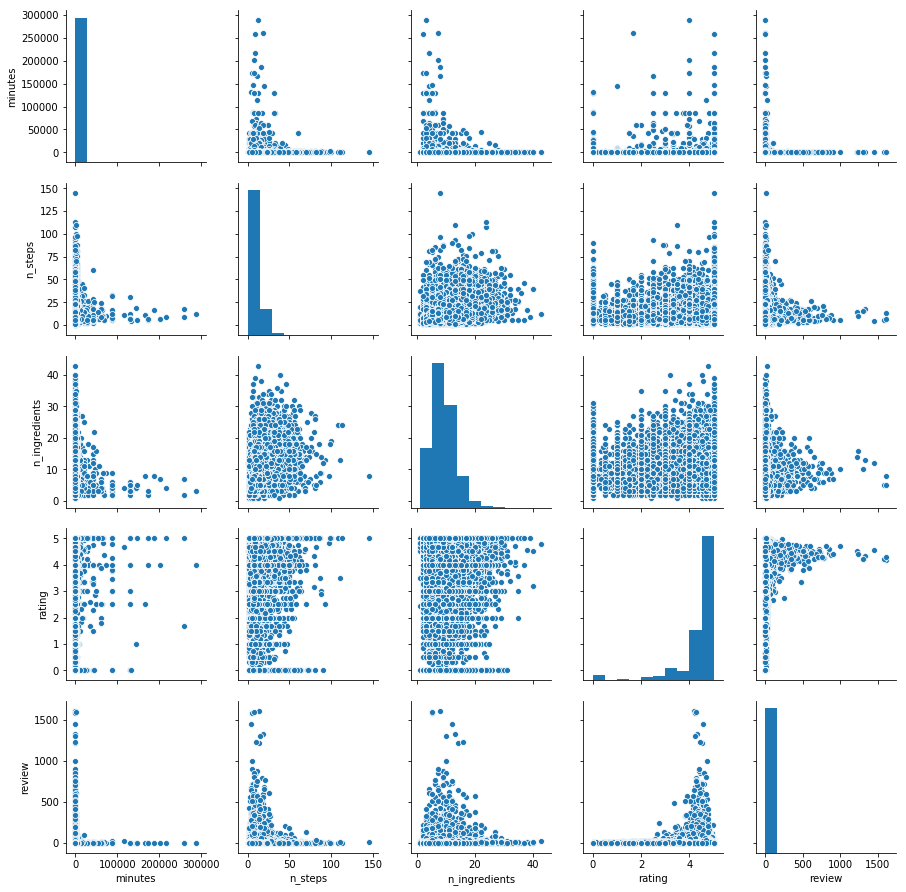

In [19]:
sns.pairplot(recipes[['minutes','n_steps','n_ingredients','rating','review']])

In [20]:
"""
Steps are list types in pandas Series. Prints steps in readable manner for any passed list containing recipe steps.
"""
def getStepsFromList(innerList):
    for i in range(len(innerList)):
        print("Step "+str(i+1)+": "+innerList[i]+"\n")

In [21]:
#stepTEST=recipes['steps'][0]
#getStepsFromList(stepTEST)

In [22]:
"""
Ingredients are list types in pandas Series. Prints ingredients in readable manner for any passed list containing recipe ingredients.
"""
def getIngredientsFromList(innerList):
    print("All ingredients needed:\n")
    for i in range(len(innerList)-1):
        print(innerList[i].capitalize()+", ")
    print(innerList[len(innerList)-1].capitalize()
          +".\nTry the recipe yourself!\n") #Print last ingredient without comma at the end

In [23]:
#ingTest=recipes['ingredients'][0]
#getIngredientsFromList(ingTest)

In [24]:
"""
Displays bar plot of top rated recipes along with Nutritional Values. Adds calories amount above each recipe's bar plot.
Parameters:
-results: Dataframe of recipes. Usually generated through getRecipes() method
-maxBarsNum: Max number of recipes to generate a barplot for
"""
def BarTopRecipes(results,maxBarsNum=5):
    
    #Copy of results so no issue if any alteration made and TAKING MAX 5 recipes
    topRes= results.copy()
    topRes.sort_values(by=['review','rating'],ascending=False,inplace=True) #DESCENDING BASED ON RATING AND #REVIEWS
    topRes['nutritionNOCAL']=topRes['nutrition'].apply(lambda inLst: inLst[1:])
    topRes= topRes.head(maxBarsNum) #Shows top 5 or less results
    
    #Taking vals for xpositions of bar
    barXpos=np.array([1,2,3,4,5,6])
    topRecipes= topRes[['name','nutrition','nutritionNOCAL']]
    
    #LABELS AND COLORS
    labels='Total Fat (%),Sugars (%),Sodium (%),Protein (%),Saturated Fat (%),Total Carbohydrates (%)'.split(",")
    handles=[]
    colors=['lightblue','orangered','navy','green','purple','plum']
    
    #height of TALLEST BAR
    highestBar=topRecipes['nutritionNOCAL'].apply(lambda inLst: max(inLst)).max()

    #Setting the PLAIN GRAPH FIRST
    plt.figure(figsize=(20,10))
    
    
    #Title
    plt.ylim(top=highestBar+25) #SET YLIM so if highest bar is first recipe, it won't block the title since +20 y space set and title set at +10 (see below)
    plt.text(0.25,highestBar+10,"Nutrition Percentage Daily Value (PDV)" , 
             fontsize=16,
             rotation=0,
             color='Black',fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='salmon', alpha=0.5),
            )

    #Calories numbers and barplot for each recipe
    for i in range(len(topRecipes)):


        plt.bar(x= 8*i + barXpos, height=topRecipes['nutritionNOCAL'].iloc[i], color =colors)
        #Name values
        plt.xticks([num*8 +3.5 for num in range(len(topRecipes))], topRecipes['name'].values,rotation=-90, fontsize=15
                  ,color='crimson',fontweight='bold')

        #Nutrition column since need Calorie number
        topBar=max(topRecipes['nutritionNOCAL'].iloc[i])
        plt.text(8*i +1,topBar+2, str(topRecipes['nutrition'].values[i][0])+" Calories", 
                 fontsize=14, rotation=0,
                 color='teal',fontweight='heavy')






    #legend
    for i in range(len(colors)):
        handles.append(mpatches.Patch(color=colors[i], label=labels[i]))

    plt.legend(handles=handles, loc='lower left',bbox_to_anchor=(0, 1.01,10,10),
               ncol=len(colors),fontsize=15)
    
    
    #show
    plt.style.use('fast')
    plt.show()

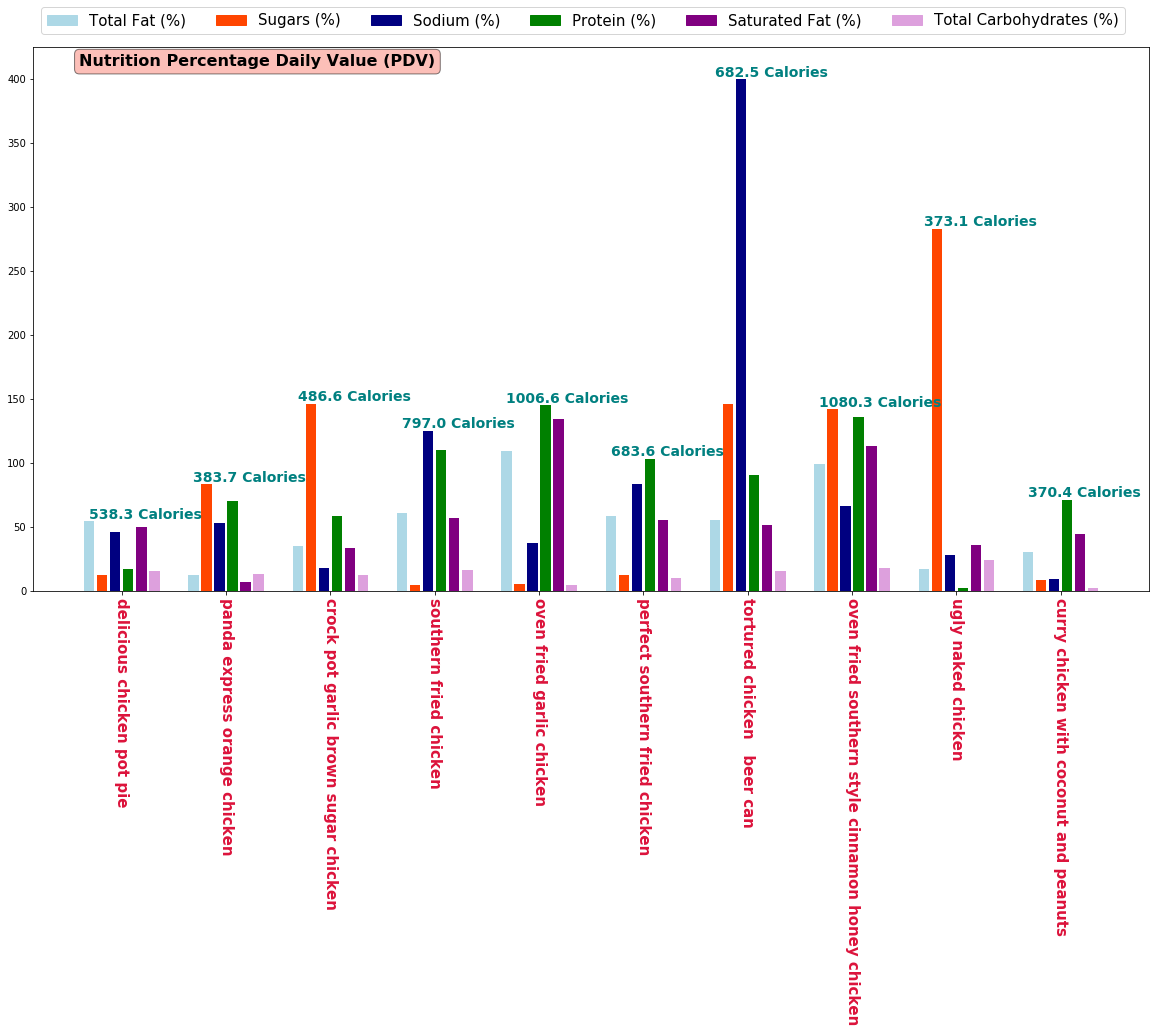

In [25]:
BarTopRecipes(getRecipes(['chicken']),10)

In [26]:
"""
Complete program running example based on ingredient inputs.
Parameters:
-results: Dataframe of recipes
-maxBarsNum: Max number of recipes to plot barplot of in generated graph. (Top # of recipes to gen a barplot)
-showTopX: Display only specified top number of recipes in case a very small amount of ingredient
input resulting in too many recipes found.
"""
def userChooseRecipe(results,maxBarsNum=5,showTopX=15):
    try:
        results.sort_values(by=['review','rating'],ascending=False,inplace=True) #DESCENDING BASED ON RATING AND #REVIEWS
        
        #Display DataFrame and Rename columns to look nicer
        display(
            results[['id','name','minutes','n_steps','n_ingredients','steps','rating','review']].rename(
            columns={'id':'Recipe ID',
                        'name':'Recipe',
                        'minutes':'Cooking Time',
                        'n_steps':'Number of Steps',
                        'n_ingredients':'Number of Ingredients',
                        'steps':'Steps',
                        'rating':'Rating /5',
                        'review':'Number of Ratings'
                       }).head(showTopX)
        )

        #User input and graph display

        BarTopRecipes(results,maxBarsNum)
        print("These are the top recipes found information. Enter the ID of the recipe you wish to make:")


        userPick=int(input())

        #Display steps of selected ID
        if(userPick in results['id'].values):
            getIngredientsFromList(results[results['id']==userPick]['ingredients'].iloc[0])#Print list of ingredients first
            getStepsFromList(results[results['id']==userPick]['steps'].iloc[0])
        else:
            print("Could not locate the input ID. CLOSING")
    except ValueError:
        print("Not an integer. CLOSING")
    except:
        print("Some input Error. Remove this else statement and run and do the same inputs to see run-time error.")
    

No recipes found. Please enter one of the ingredients to remove and search again.
H
No recipes found. Please enter one of the ingredients to remove and search again.
y


,Recipe ID,Recipe,Cooking Time,Number of Steps,Number of Ingredients,Steps,Rating /5,Number of Ratings
9,133760,hainanese chicken rice,1465,32,19,[first of all wash the rice then place it on t...,4.681818,22
2,248707,basic fried rice with variations,55,16,38,"[dice or shred meat and vegetables, heat oil i...",4.571429,14
4,227371,chicken shawarma recipe,65,19,19,"[combine all ingredients except for chicken , ...",4.125000,8
7,151591,greek salad with grilled chicken,35,8,16,"[prepare grill or broiler, combine first 8 ing...",5.000000,3
0,362986,all in one roast chicken dinner,100,18,18,[heat oven to 350 deg f / 180 deg celsius use ...,3.333333,3
5,371885,couscous garbanzo salad,15,11,16,"[bring broth to a boil in medium saucepan , an...",5.000000,2
10,466401,indian inspired chicken with raita,50,10,14,"[mix 1 cup yogurt , 2 cloves garlic , salt thr...",5.000000,2
11,35551,indonesian fried rice nasi goreng,25,7,13,[stir the rice with a fork to separate the gra...,5.000000,2
6,391850,delicate cucumber and strawberry tea slices,5,4,7,"[cut cucumber into coin sized slices, finely c...",3.000000,2
3,195246,chicken shawarma quick healthy and simple sa...,25,13,18,[mix boneless and sliced / cubed chicken piece...,0.500000,2


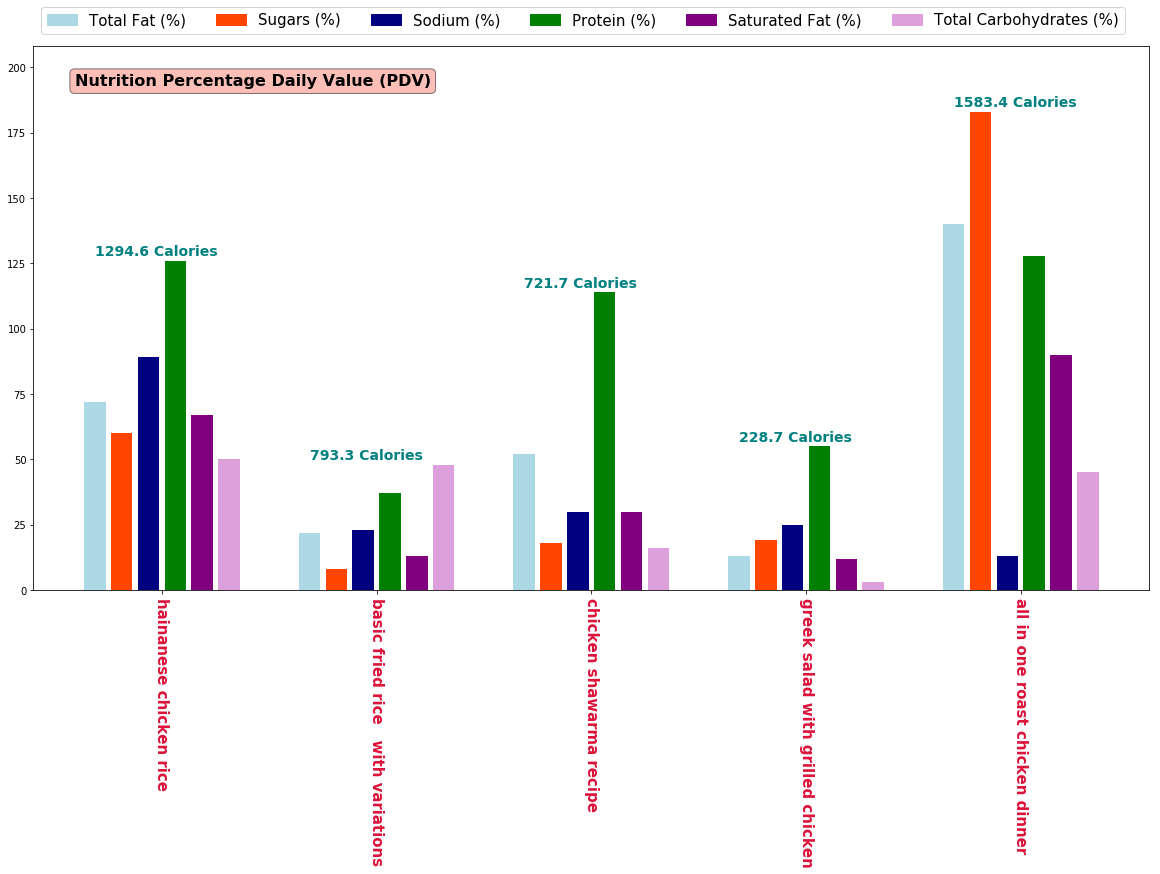

These are the top recipes found information. Enter the ID of the recipe you wish to make:
287442
All ingredients needed:

Cooked rice, 
Red onion, 
Red chilies, 
Prawns, 
Chicken, 
Soy sauce, 
Oil, 
Salt, 
Pepper, 
Red chile, 
Fresh coriander leaves, 
Cucumbers, 
Egg, 
Spring onions.
Try the recipe yourself!

Step 1: heat the oil in a pan and fry the onions and chillies till light brown

Step 2: add the prawns and chicken cook for 1 minute

Step 3: add the rice , season with the soy , salt and pepper

Step 4: fry for a few mins till the rice is heated through

Step 5: serve garnished with the remaining ingredients



In [27]:
userChooseRecipe(getRecipes(['chicken','salt','cucumber','H','Y']))

,Recipe ID,Recipe,Cooking Time,Number of Steps,Number of Ingredients,Steps,Rating /5,Number of Ratings
10,12572,savory crescent chicken squares,30,5,9,[blend cream cheese with 2 tbsp butter until s...,4.611111,72
4,22806,chicken manicotti with chive cream sauce,60,15,9,[cook manicotti according to package direction...,4.444444,9
3,59408,chicken in a hut,28,9,6,"[combine all ingredients except rolls, set asi...",4.750000,4
0,314433,chicken broccoli cheesy casserole,45,17,6,"[rinse and drain broccoli, chop up the broccol...",4.666667,3
1,409042,chicken broccoli crescent squares,35,7,8,"[blend cream cheese with butter, add chicken ,...",4.666667,3
2,330329,chicken cream cheese puffs,50,6,9,[blend all ingredients except chicken and crou...,5.000000,2
8,406780,kraft creamy chicken and pasta casserole,55,10,9,"[heat oven to 350 degrees, spray a nonstick sk...",5.000000,2
12,454624,white meatza,25,20,8,"[preheat oven to 375 degress, prepare a baking...",5.000000,2
11,67887,super simple broccoli and chicken or shrimp ...,30,8,10,[cook broccoli according to package directions...,1.000000,2
5,463669,cream cheese chicken lasagna,65,22,14,[cook lasagna noodles to desired doneness as d...,5.000000,1


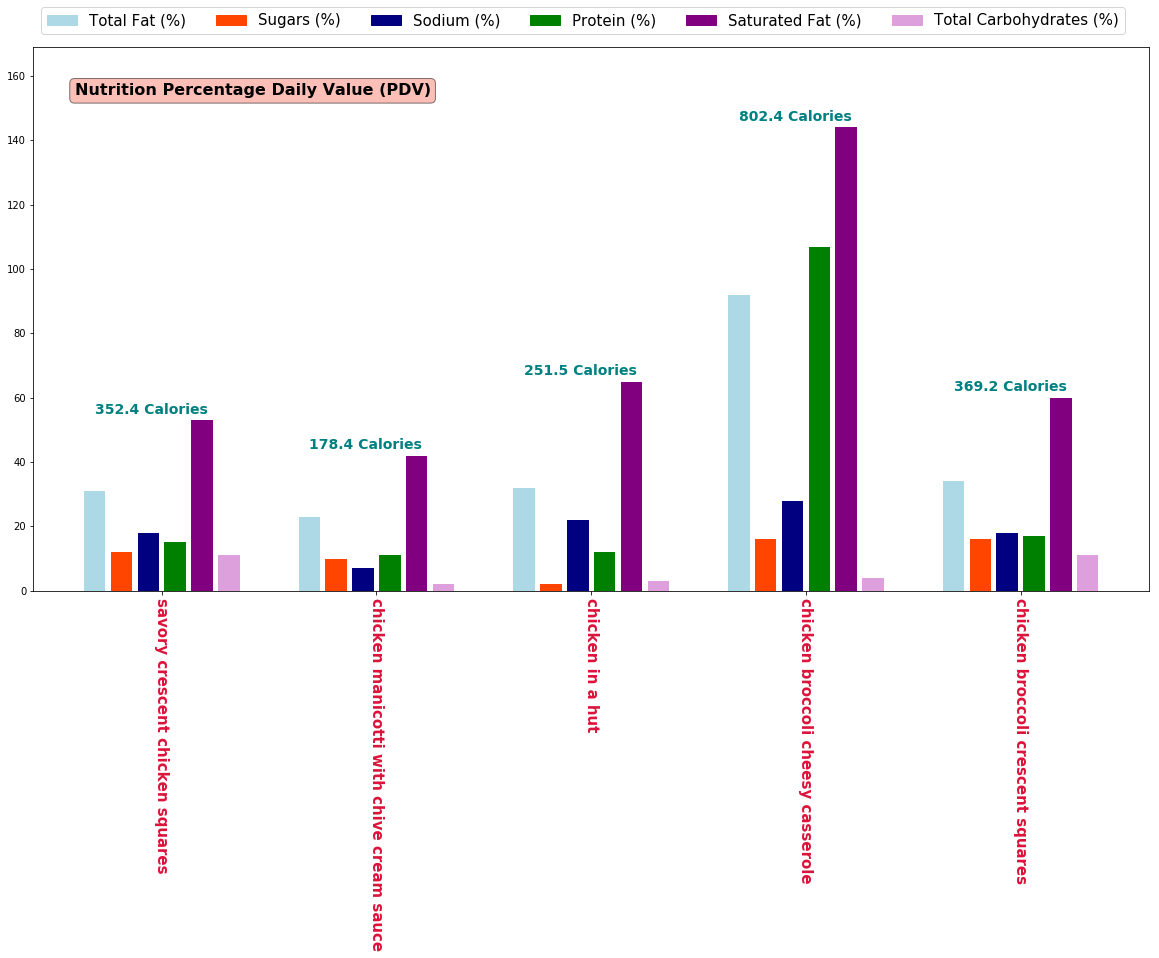

These are the top recipes found information. Enter the ID of the recipe you wish to make:
12572
All ingredients needed:

Cream cheese, 
Butter, 
Boneless chicken, 
Salt and pepper, 
Milk, 
Onion, 
Olive, 
Refrigerated crescent dinner rolls, 
Crouton.
Try the recipe yourself!

Step 1: blend cream cheese with 2 tbsp butter until smooth

Step 2: add next five ingredients and mix well

Step 3: spoon 1 / 2 c meat mixture onto 2"triangles" of dough

Step 4: pull 4 corners to the top , center of mixture and twist slightly and seal edges by pinching

Step 5: brush tops with remaining butter and sprinkle with croutons bake on ungreased cookie sheet for 20-25 minutes in a 350 oven until golden brown



In [28]:
userChooseRecipe(getRecipes(['chicken','milk','cream cheese']),5,15)